# Extra Exercise project 4 – RNN/LSTM for time series forecasting (Cimate dataset)

This notebook aimed to refine the previous LSTM model by making architectural adjustments to improve the prediction of meantemp based on historical climate data. The goal was to test a more efficient approach by modifying the architecture and training strategy.

https://medium.com/aiskunks/daily-climate-forecasting-time-series-forecasting-using-lstm-recurrent-neural-nets-bbe6f425c688

### Step 0: Importing libraries and loading the dataset

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf

In [ ]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_4/"  # Replace with your CSV file path
os.chdir(folder_path)

In [ ]:
df = pd.read_csv("data/daily_climate.csv")

### Step 1: Data analysis and visualisations

In [ ]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

In [ ]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


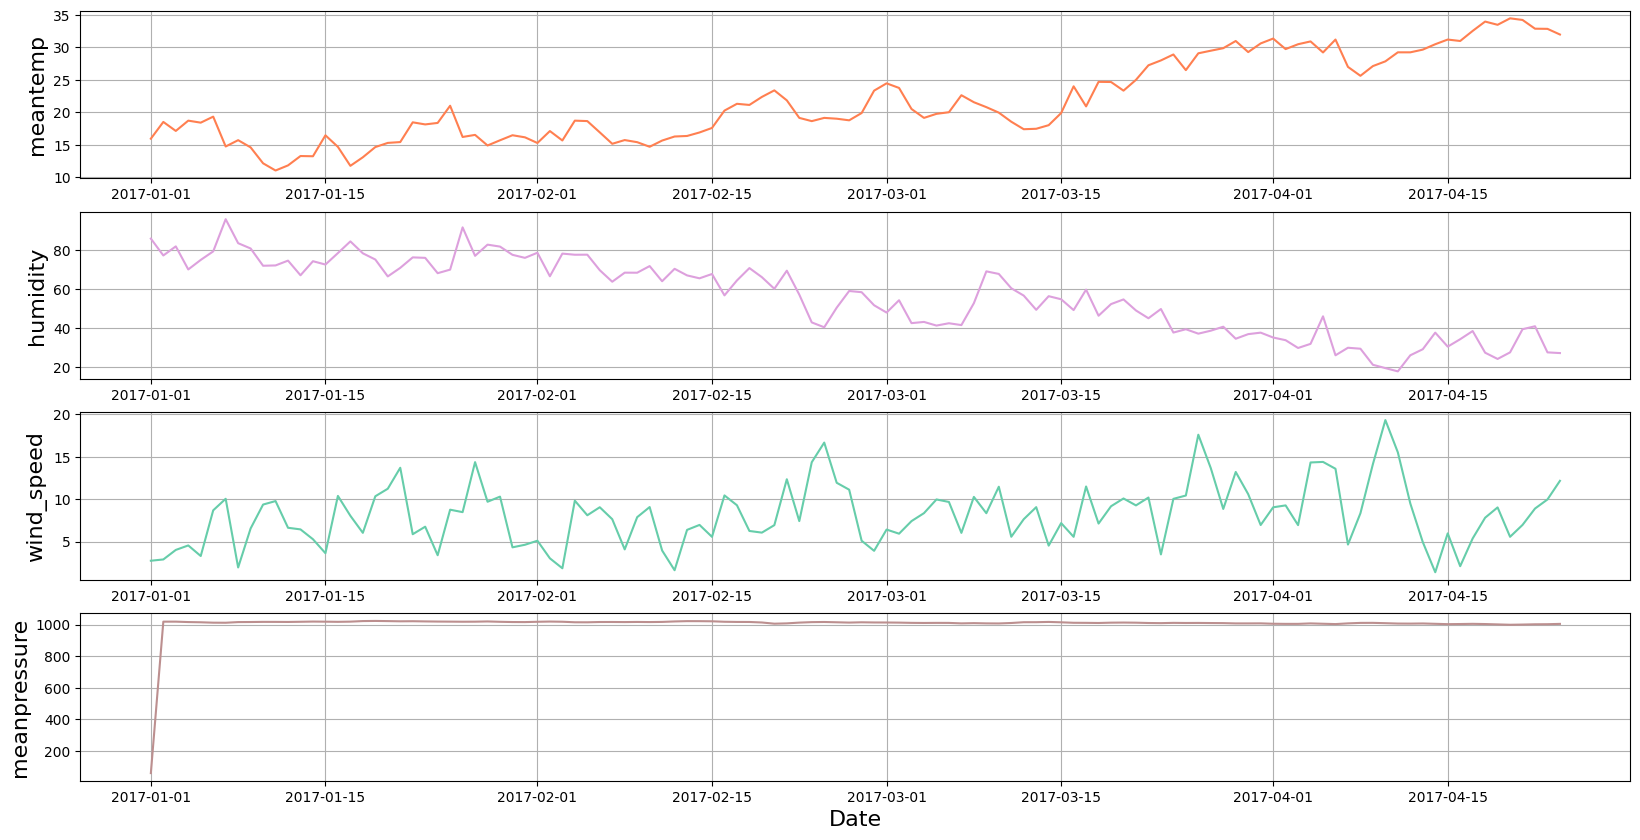

In [ ]:
plt.figure(figsize=(20, 10))
colors = ['#FF7F50', '#DDA0DD', '#66CDAA', '#BC8F8F']
for i, col in enumerate(df.set_index('date').columns):
    plt.subplot(len(df.set_index('date').columns), 1, i + 1)
    plt.plot(df.set_index('date')[col], color=colors[i])
    plt.ylabel(col, fontsize=16)
    plt.grid()
plt.xlabel('Date', fontsize=16)
plt.show()

### Step 2: Data pre-processing

In [ ]:
result = adfuller(df["meantemp"])
print(f"ADF test statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical thresholds:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

ADF test statistic: -1.096474275875619
p-value: 0.7164758731775932
Critical thresholds:
	1%: -3.489589552580676
	5%: -2.887477210140433
	10%: -2.580604145195395


In [ ]:
df["meantemp_log"] = np.log(df["meantemp"])
df["meantemp_transformed"] = df["meantemp_log"].diff(periods=12)  # Differencing for seasonality
df.dropna(inplace=True)

In [ ]:
result = adfuller(df["meantemp_transformed"])
print(f"Post-transform ADF test statistic: {result[0]}")
print(f"Post-transform p-value: {result[1]}")

Post-transform ADF test statistic: -3.059454941188219
Post-transform p-value: 0.029702871419171814


In [ ]:
# Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['date']))
scaled_df = pd.DataFrame(scaled_data, columns=df.drop(columns=['date']).columns)

In [ ]:
# Sliding Window
def create_window(target, feature, window=1, offset=0):
    feature_new, target_new = [], []
    feature_np = feature.to_numpy()
    target_np = target.to_numpy()
    for i in range(window, target.shape[0] - offset):
        feature_list = feature_np[i - window:i]
        feature_new.append(feature_list.reshape(window, feature_np.shape[1]))
        target_new.append(target_np[i+offset].reshape(1))
    return np.array(feature_new), np.array(target_new)

window = 10
feature_columns = ['humidity', 'wind_speed', 'meanpressure', 'meantemp']
features, target = create_window(scaled_df['meantemp'], scaled_df[feature_columns], window=window)

In [ ]:
# Train-Test Split
def train_test_split(features, target, perc_train=0.9):
    train_size = int(len(features) * perc_train)
    x_train = features[:train_size]
    y_train = target[:train_size]
    x_test = features[train_size:]
    y_test = target[train_size:]
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_split(features, target)

### Step 3: Model Architecture

This model was simplified compared to the previous one.

In [ ]:
Sequential = tf.keras.models.Sequential
LSTM = tf.keras.layers.LSTM
Dense = tf.keras.layers.Dense
Input = tf.keras.layers.Input

In [ ]:
# LSTM Model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape[1], input_shape[2])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(input_shape[2]))  # Output dimension equals feature dimension
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = create_lstm_model(x_train.shape)

In [ ]:
# Model Training
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - loss: 0.6530 - val_loss: 1.8585
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4032 - val_loss: 1.1131
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2883 - val_loss: 0.4722
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2335 - val_loss: 0.1938
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2039 - val_loss: 0.1706
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2067 - val_loss: 0.3087
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1803 - val_loss: 0.4508
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1854 - val_loss: 0.5397
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1763 - val_loss: 0.5326
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1660 - val_loss: 0.5156
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1538 - val_loss: 0.4671
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1541 - val_loss: 0.4967


### Step 4: Model Evaluation

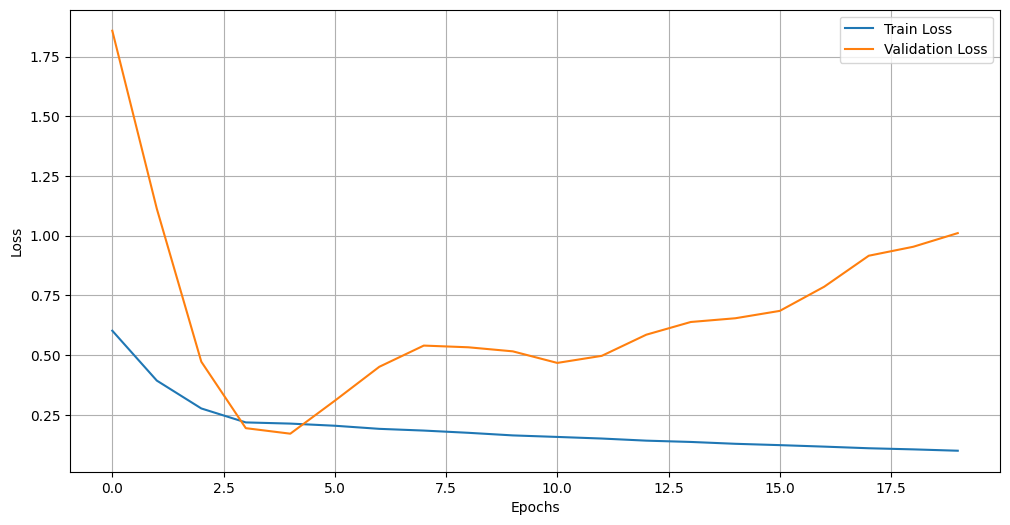

In [ ]:
# Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Model Evaluation
y_pred = model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


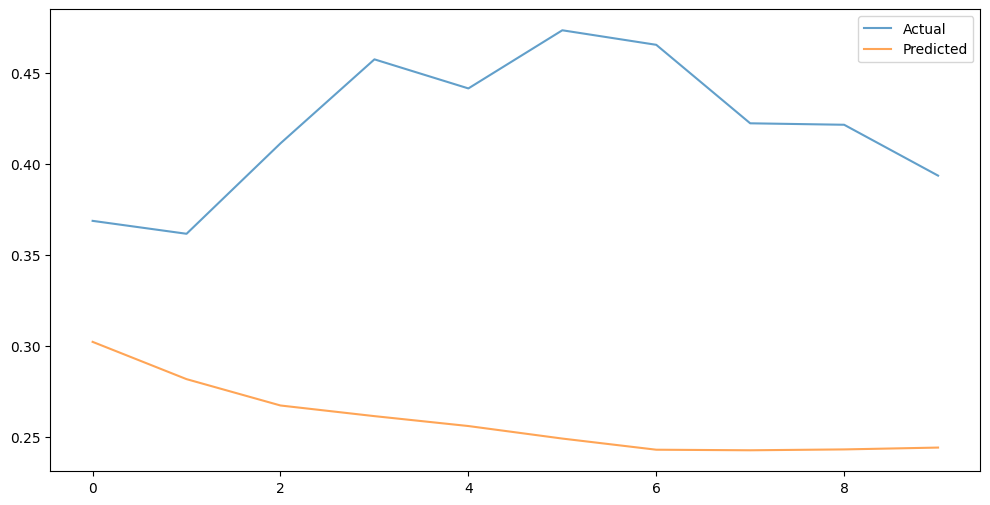

In [ ]:
# num of features in the original scaled data
num_features = scaled_df.shape[1]

y_test_padded = np.zeros((y_test.shape[0], num_features))  # padded array
y_test_padded[:, -1] = y_test.flatten()  # Place y_test in the last column
y_test_rescaled = scaler.inverse_transform(y_test_padded)[:, -1]  # meantemp

# Extract the correct target predictions (meantemp) from y_pred
y_pred_target = y_pred[:, -1]  # meantemp is the last column

# Ensure shapes are consistent for y_pred
y_pred_padded = np.zeros((y_pred.shape[0], num_features))  # padded array
y_pred_padded[:, -1] = y_pred_target.flatten()  # Place y_pred in the last column
y_pred_rescaled = scaler.inverse_transform(y_pred_padded)[:, -1]  # meantemp

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual", alpha=0.7)
plt.plot(y_pred_rescaled, label="Predicted", alpha=0.7)
plt.legend()
plt.show()

### Personal Analysis / Refelection


The small dataset of 365 instances made it hard for the complex model to generalize well, leading to overfitting. It performed well on training data but struggled with validation data. Predicting multiple features at once instead of just focusing on meantemp likely hurt performance, and training for only 20 epochs may not have been enough to capture meaningful trends.

Improving the model could be done by using fewer neurons and LSTM layers and adding more data to help it learn better.
